In [1]:
import pandas as pd
import numpy as np

# read news results dataset
dataset_A = pd.read_csv(f'data/dataset_A.csv')

# read the all news domain visits dataset
dataset_B = pd.read_csv(f'data/dataset_B.csv')

# read Google independent dataset
dataset_D = pd.read_csv(f'data/dataset_D.csv')

# read all domain visits (news and not newws)
dataset_E = pd.read_csv(f'data/dataset_E.csv')

# read all the google selected results
google_selected = pd.read_csv(f'data/non_news_selected_google_results.csv')

# include only the participants that were part of the statistical test
set_participants = set(dataset_A[dataset_A['is_selected_result']]['participant'])


# Rank calculations

## Rank on news selection

In [2]:
# consider only the ones that were match
news_matches = dataset_A[dataset_A['is_selected_result']].copy()

# categorize the rank so that it is displayed correctly in the X-axis
news_matches['Rank'] = news_matches['rank'].astype("category")

# calculate the proportion within the participant
tp_news_ch = (news_matches.groupby(['participant', 'Rank']).size() 
              / news_matches.groupby(['participant']).size()).rename('Proportion').reset_index()

# name the dataset
tp_news_ch['Data Set']  = 'News articles'


## Rank in exposure

In [3]:
# consider only the ones that were match
exposure = dataset_A.copy()

# categorize the rank so that it is displayed correctly in the X-axis
exposure['Rank'] = exposure['rank'].astype("category")

# calculate the proportion within the search page (which is also within the participant but it makes more sense)
tp_exposure = exposure.groupby(['search_page', 'Rank']).size().rename('Proportion').reset_index()

# merge the total results per page back
tp_exposure = tp_exposure.merge(exposure[['search_page', 'total_results_per_page']].drop_duplicates(), how='left', on='search_page')

# mark the ones with rank above the total results per page as missings
tp_exposure.loc[tp_exposure['Rank'].astype(int) > tp_exposure['total_results_per_page'], 'Proportion'] = None

# name the dataset
tp_exposure['Data Set']  = 'Exposure'

tp_exposure.shape

(12210, 5)

## Non news rank

In [4]:

# categorize the rank so that it is displayed correctly in the X-axis
google_selected['Rank'] = google_selected['rank'].astype("category")

# calculate the proportion within the participant
tp_google_selected = (google_selected.groupby(['participant', 'Rank']).size() 
              / google_selected.groupby(['participant']).size()).rename('Proportion').reset_index()

# name the dataset
tp_google_selected['Data Set']  = 'Non news'


# Visits per participants

## News visits (Dataset B)

In [5]:
# distribution of news visitors
news_B_visitors = dataset_B.groupby(['participant']).size()

# represent all participant even if they didn't have a news visit
news_B_visitors = news_B_visitors.reindex(set_participants).fillna(0).astype(int).sort_index()

## Non news visits 

In [6]:
# count visits per participant
non_news_domain_visitors = dataset_E.groupby([ 'participant']).size()

# include all participants by reindixing wit all participants
non_news_domain_visitors = non_news_domain_visitors.reindex(set_participants).fillna(0).astype(int).sort_index()

# Integrated plot

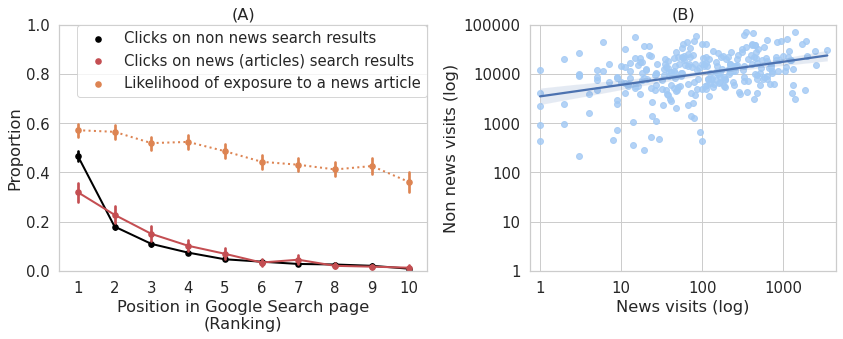

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau

sns.set(style="whitegrid", font_scale=1.35)
fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'width_ratios': [6, 5]})

# sns.set(style="whitegrid", font_scale=1.3)

# concatenate the calculated datasets per participant
toplot = pd.concat([tp_google_selected, tp_news_ch, tp_exposure])

# set descriptive names to the legends
legend_names = {
    'Non news': 'Clicks on non news search results',
    'News articles': 'Clicks on news (articles) search results',
    'Exposure': 'Likelihood of exposure to a news article'
}

# assigng the names to the data set column label
toplot['Data Set'] = toplot['Data Set'].map(legend_names)

# better name for the column
toplot = toplot.rename(columns = {'Rank': 'Position in Google Search page\n(Ranking)'})

# fig, ax = plt.subplots(1,1, figsize=(8,5))

pp = sns.pointplot(x="Position in Google Search page\n(Ranking)", 
                   y="Proportion", 
                   data=toplot,
                   hue='Data Set',
                   hue_order = list(legend_names.values()),
                   join=True, 
                   scale=.75, 
                   ci=95,
                   log=True,
                   palette = [ "black", sns.color_palette()[3], sns.color_palette()[1]],
                   linestyles = ["solid", "solid", 'dotted'],
                   ax=ax[0]
                  )

# this removes the legend of the title
# pp.legend()

#place legend outside top right corner of plot
pp.set_ylim([0,1])
pp.legend(borderaxespad=0)#bbox_to_anchor=(1.02, 1), loc='center right', borderaxespad=-3)
pp.set_title('(A)')


################################################################
# Plot A:  Scatterplot between news visits and non news visits #
################################################################


# scatterplot with linear regression
rp = sns.regplot(x=np.log10(news_B_visitors), 
                 y=np.log10(non_news_domain_visitors), 
                 color=sns.color_palette('pastel')[0],  
                 line_kws={'color': sns.color_palette()[0]},
                 ci=95,
                 ax=ax[1]
                )

# set logarithmic axis so they match the x and y transformation
rp.set_xticks(np.log10(np.array([1, 10, 100, 1000, 10000])))
rp.get_xaxis().set_major_formatter(lambda x, pos: f'{10 ** x:g}')
rp.set_xlim(np.log10(np.array([.75, max(news_B_visitors)+1000])))
rp.set_yticks(np.log10(np.array([1, 10, 100, 1000, 10000, 100000])))
rp.get_yaxis().set_major_formatter(lambda x, pos: f'{10 ** x:g}')
rp.set_ylim(np.log10(np.array([1, 100001])))

# add labels and titles
rp.set_xlabel('News visits (log)')
rp.set_ylabel('Non news visits (log)')
rp.set_title('(B)')


plt.tight_layout()

# Descriptives, tests and comparisons

## General descriptives of news visits  (incl. proportion to all visits)

In [8]:
news_visits_per_participant = dataset_B.groupby('participant').size()
dataset_E_per_participant = dataset_E.groupby('participant').size()

google_independent_visits_per_participant = dataset_D.groupby('participant').size()

print('News visits per participant accross the entire period:')
print(news_visits_per_participant.describe())

print(f'\n\nProportion of news visits to all visits (per participants):')
print((100 * news_visits_per_participant / (news_visits_per_participant + dataset_E_per_participant)).describe())


print('\n\nParticipants with less than 10 visits:', (news_visits_per_participant < 10).sum(), 
      f'({round(100 * (news_visits_per_participant < 10).sum() / len(news_visits_per_participant),5)}%)')
print('Participants with less than 100 visits:', (news_visits_per_participant < 100).sum(), 
      f'({round(100 * (news_visits_per_participant < 100).sum() / len(news_visits_per_participant),5)}%)')
print('Participants with more than 1000 visits:', (news_visits_per_participant > 1000).sum(),
      f'({round(100 * (news_visits_per_participant > 1000).sum() / len(news_visits_per_participant),5)}%)')

print('\n\nParticipants with no Google independent visits:', 
      len(set_participants) - len(google_independent_visits_per_participant), 
     'out of', len(set_participants), 
      f'({ 100 * (len(set_participants) - len(google_independent_visits_per_participant)) / len(set_participants)}%)')

News visits per participant accross the entire period:
count     280.000000
mean      271.110714
std       448.588721
min         1.000000
25%        27.000000
50%        90.500000
75%       324.500000
max      3480.000000
dtype: float64


Proportion of news visits to all visits (per participants):
count    280.000000
mean       2.318502
std        3.885876
min        0.008307
25%        0.266602
50%        1.017751
75%        2.400650
max       30.697260
dtype: float64


Participants with less than 10 visits: 29 (10.35714%)
Participants with less than 100 visits: 146 (52.14286%)
Participants with more than 1000 visits: 19 (6.78571%)


Participants with no Google independent visits: 23 out of 280 (8.214285714285714%)


## T-test for the top result

In [9]:
from scipy.stats import ttest_ind
from IPython.display import display

nonnews_selections = tp_google_selected[tp_google_selected['Rank'] == 1]['Proportion']
news_selections = tp_news_ch[tp_news_ch['Rank'] == 1]['Proportion']


display(pd.concat([
    nonnews_selections.describe().rename('Non news selections') * 100,
    news_selections.describe().rename('News selections') * 100,
], axis=1))

print('ttest non Google associated vs Google Search associated ( df =',
      nonnews_selections.dropna().count() + 
      news_selections.dropna().count() - 2,
      '):\n',
      ttest_ind(
          nonnews_selections.dropna(),
          news_selections.dropna()
      ))


,Non news selections,News selections
count,27900.000000,28000.000000
mean,46.711082,31.962236
std,16.325370,33.110406
min,0.000000,0.000000
25%,35.865705,0.000000
50%,45.614035,25.000000
75%,55.372117,50.000000
max,100.000000,100.000000


ttest non Google associated vs Google Search associated ( df = 557 ):
 Ttest_indResult(statistic=6.675630480244785, pvalue=5.962331820381155e-11)


## Correlations for rank vs exposure

In [10]:
from scipy.stats import pearsonr, spearmanr, kendalltau

# consider only pages with exactly 10 results
exposure10 = dataset_A[dataset_A['total_results_per_page'] == 10].copy()

# categorize the rank so that it is displayed correctly in the X-axis
exposure10['Rank'] = exposure10['rank'].astype("category")

# calculate the proportion within the participant
tp_exposure10 = (exposure10.groupby(['search_page', 'Rank']).size()).rename('Proportion').reset_index()

# name the dataset
tp_exposure10['Data Set']  = 'Exposure'

print('Degrees of Freedom: ', len(tp_exposure10) - 2)
print('\nSpearman correlation of Google associated news visits and non news visits', 
      spearmanr(tp_exposure10['Rank'], tp_exposure10['Proportion']))
print('Kendal Tau correlation of Google associated news visits and non news visits', 
      kendalltau(tp_exposure10['Rank'], tp_exposure10['Proportion']))
print('Pearson correlation of Google associated news visits and non news visits', 
      pearsonr(tp_exposure10['Rank'], tp_exposure10['Proportion']))

Degrees of Freedom:  5548

Spearman correlation of Google associated news visits and non news visits SpearmanrResult(correlation=-0.11311474977530975, pvalue=2.86111909719944e-17)
Kendal Tau correlation of Google associated news visits and non news visits KendalltauResult(correlation=-0.09686568459609086, pvalue=3.5737723472596655e-17)
Pearson correlation of Google associated news visits and non news visits (-0.1131147497753099, 2.861119097230804e-17)


# Correlation of news and non-news visits

In [11]:
print('Degrees of Freedom: ', len(news_B_visitors) - 2)

# Google associated and Google independent 
print('\nCorrelation of news visits and non news visits:')
# print('Degrees of Freedom: ', len(tp_exposure10) - 2)
print('Spearman:', 
      spearmanr(news_B_visitors, non_news_domain_visitors))
print('Kendal Tau:', 
      kendalltau(news_B_visitors, non_news_domain_visitors))
print('Pearson:', 
      pearsonr(news_B_visitors, non_news_domain_visitors))


Degrees of Freedom:  278

Correlation of news visits and non news visits:
Spearman: SpearmanrResult(correlation=0.34505658366509945, pvalue=3.0067211418223126e-09)
Kendal Tau: KendalltauResult(correlation=0.23953462482553764, pvalue=2.4404810622766765e-09)
Pearson: (0.2758325477818187, 2.7840802103516874e-06)
